In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip


--2025-02-28 12:36:06--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.163.189.36, 3.163.189.46, 3.163.189.89, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.163.189.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  7.46MB/s    in 0.4s    

2025-02-28 12:36:07 (7.46 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import string
import unicodedata
import glob
import os
import time
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
allowed_characters = string.ascii_letters + " .,;'"
n_letters = len(allowed_characters)


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [ ]:
def letterToIndex(letter):
    return allowed_characters.find(letter)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [ ]:


class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [ ]:
class rNN(torch.nn.Module):
    def __init__(self, inps, hids):
        super(rNN, self).__init__()
        self.W_hh = nn.Linear(hids, hids, bias=False)  # Hidden-to-hidden weights
        self.W_xh = nn.Linear(inps, hids, bias=False)  # Input-to-hidden weights
        self.hidd = None  # Hidden state, initialized dynamically

    def step(self, x):
        if self.hidd is None or self.hidd.shape[0] != x.shape[0]:
            self.hidd = torch.zeros(x.size(0), self.W_hh.in_features, device=x.device)
        else:
            self.hidd = self.hidd.detach()  # Fix: Detach hidden state to stop gradient accumulation

        self.hidd = torch.tanh(self.W_hh(self.hidd) + self.W_xh(x))
        return self.hidd

    def forward(self, inp):
        seq_len, batch_size, _ = inp.shape
        hidden_states = []

        # Iterate over each time step
        for t in range(seq_len):
            hidden_state = self.step(inp[t])
            hidden_states.append(hidden_state)

        return torch.stack(hidden_states)




class charRNN(torch.nn.Module):
    def __init__(self,inps,hids,outs):
      super(charRNN, self).__init__()
      self.rNN = rNN(inps,hids)
      self.hid = torch.nn.Linear(hids,outs)
      self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self,inp):
      hidd = self.rNN(inp)
      out = self.hid(hidd[-1])
      out = self.softmax(out)
      return out


In [ ]:
alldata = NamesDataset("data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([5]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]]), 'Korean', 'Ahn')


In [ ]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device='cpu').manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


In [ ]:
n_hidden = 128
rnn = charRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

charRNN(
  (rNN): rNN(
    (W_hh): Linear(in_features=128, out_features=128, bias=False)
    (W_xh): Linear(in_features=57, out_features=128, bias=False)
  )
  (hid): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input)
print(label_from_output(output, alldata.labels_uniq))

('Portuguese', 10)


In [ ]:
import random
import numpy as np

def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = torch.nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [ ]:
start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end = time.time()
print(f"training took {end-start}s")

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.9813510914183958
10 (37%): 	 average batch loss = 0.9199360845301315
15 (56%): 	 average batch loss = 0.88409040753658
20 (74%): 	 average batch loss = 0.8641242217128162
25 (93%): 	 average batch loss = 0.8536891624598644
training took 515.7440867424011s


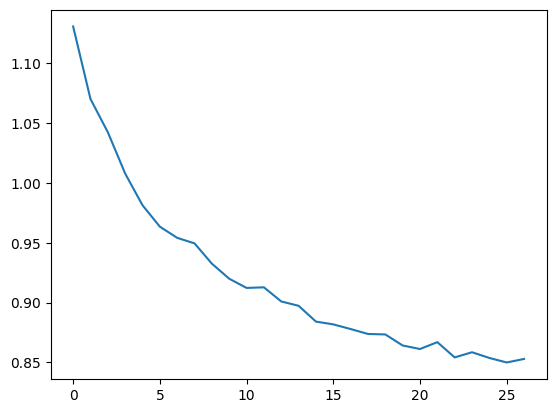

In [ ]:
plt.figure()
plt.plot(all_losses)
plt.show()

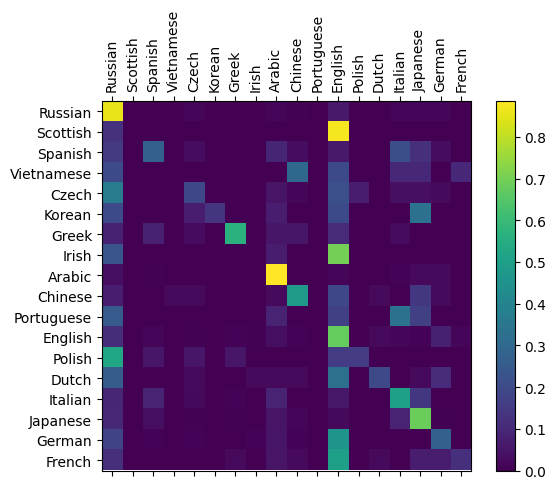

In [ ]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_uniq)